# Introduction to Regression II: Random Feature Models

We'll do two experiments.

- Experiment A: Try to predict Google's stock using a historical rolling window.

- Experiment B: Try to predict Google's stock using Apple's stock.

In [1]:
# Set True for Experiment A and False for Experiment B!
Experiment_A = False

## Getting Started
Let's start with the basics and some artificial data!

### Initializations

Initialize/Import some basic packages

*Make sure to comment your code so you can remember what it does in 2+ days :P*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# Let's ignore warnings (they're annoying and we know what's up)
import warnings
warnings.filterwarnings("ignore")

ML Models

In [3]:
from sklearn.linear_model import LinearRegression

Let's load our real data again.

In [4]:
# This package pulls, data from finance
import yfinance as yf

---

Since we'll be randomizing things; we want our experiments to be reproducible...
So let's set a seed!

In [5]:
import random
np.random.seed(2022) # Numpy uses a different (random) seed :/
random.seed(2022)

### Let's gather our hyperparameters here

#### Size of Test Set

In [6]:
# Number of testin points
N_test = 300

Shortly, we'll want to pick a large feature space dimension "$F$".

#### Parameters for Random Feature Maps

In [7]:
# Feature Space's Dimension
dim_feature = 10**4
# Radius for sampling random weights
radius_weights = 0.25 # <- Should be positive
# Radius for sampling random biases
radius_bias = 1.1 # <- Should be bigger than 1

#### Building and Training our Regression Model

In [8]:
model_linReg = LinearRegression()

As last week: 
We will pull, google stock's daily closing prices from Yahoo finance as covariates.
The targets will be Google's next day price :)

We'll train on a daily 5 year period!

In [9]:
# Pull
data_raw = yf.download('GOOG','2008-01-01','2020-12-31')
# check
print('Tail')
print(data_raw.tail())
print('Head')
print(data_raw.head())

[*********************100%***********************]  1 of 1 completed
Tail
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.619003  20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.942497   6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.804497  27860000
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.935997  25988000
2020-12-30  88.100502  88.254753  86.279999  86.975998  86.975998  26122000
Head
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2008-01-02  17.257067  17.369146  16.879980  17.065783  17.065783  172921733
2008-01-03  17.067528  17.107128  16.849842  17.069269  17.069269  130587647
2008-01-04  16.928797  16.960428  16.313852  16.363665  16.363665  215195594
2008

In [10]:
# 1) Keep only the Closing Prices as covariates
# 2) Convert to Dataframe type (Manipulation of data is easier for this object class; as opposed to numpy arrays)
data_close = pd.DataFrame(data_raw.Close)

Let's visualize things

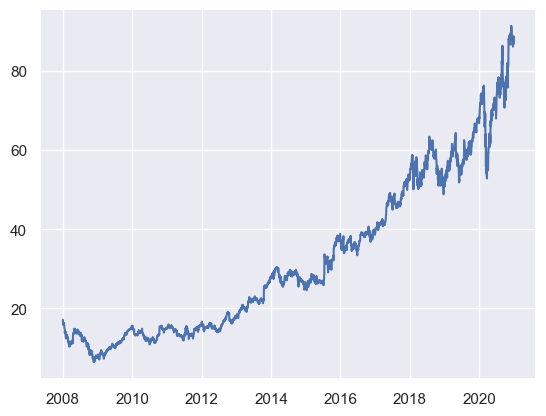

In [11]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()

# Plot!
plt.plot(data_close)

In [14]:
if Experiment_A == True:
    # The covariates 
    # The inputs will be the rolling average of the last 3 days
    data = data_close
    data['Rolling_Mean_Historical'] = data_close.shift(1).rolling(window=3).mean() 
    data = data.dropna()

    # Lets divide things up into targets and covariates
    Y = pd.DataFrame(data['Close'])
    X = pd.DataFrame(data['Rolling_Mean_Historical'])
else:
    # Pull
    Y_data_raw = yf.download('GOOG','2018-01-03','2020-12-30')
    # check
    print('Tail')
    print(Y_data_raw.tail())
    print('Head')
    print(Y_data_raw.head())

    # Pull Covariates
    X_data_raw = yf.download('AAPL','2018-01-02','2020-12-29')
    # check
    print('Tail')
    print(X_data_raw.tail())
    print('Head')
    print(X_data_raw.head())
        
        
    #NB: This is the same as in lecture 0
    
    # 1) Keep only the Closing Prices as covariates
    # 2) Convert to Dataframe type (Manipulation of data is easier for this object class; as opposed to numpy arrays)
    Y = pd.DataFrame(Y_data_raw.Close)
    X = pd.DataFrame(X_data_raw.Close)

    # Just double-check arrays are of the same size (note Jan. 1rst is a holiday)
    print(X.shape)
    print(Y.shape)

[*********************100%***********************]  1 of 1 completed
Tail
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-22  86.721497  86.870247  85.628754  86.175003  86.175003  18734000
2020-12-23  86.405502  87.399498  86.251999  86.619003  86.619003  20676000
2020-12-24  86.750000  87.300003  86.455498  86.942497  86.942497   6936000
2020-12-28  87.581749  89.536400  87.316750  88.804497  88.804497  27860000
2020-12-29  89.389503  89.622002  87.804497  87.935997  87.935997  25988000
Head
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-01-03  53.215500  54.314499  53.160500  54.124001  54.124001  28604000
2018-01-04  54.400002  54.678501  54.200100  54.320000  54.320000  20092000
2018-01-05  54.700001  55.212502  54.599998  55.111500  55.111500  25582000
2018-01-0

Let's make the last 20 days "invisible" and use them as our testing set (we'll pretend those are the too be predicted prices!).

In [15]:
# Build Train
Y_train = Y[:-N_test]
X_train = X[:-N_test]

# Build Test
Y_test = Y[:N_test]
X_test = X[:N_test]


# Visualize Dataframe Dimensions (make sure things are running reasonably!)
print('Check Train')
print(X_train.shape)
print(X_train.head())
print('Check Test')
print(X_test.shape)
X_test.head()

Check Train
(453, 1)
                Close
Date                 
2018-01-02  43.064999
2018-01-03  43.057499
2018-01-04  43.257500
2018-01-05  43.750000
2018-01-08  43.587502
Check Test
(300, 1)


,Close
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502


---
## We'll Initialize our Benchmark model

This simple/basic/vanilla model will serve as our target to beat; if we don't then we're doing something wrong :S

#### Building and Training our Regression Model

In [16]:
model_linReg = LinearRegression()

First we train our model, with the "training" (a.k.a. in-sample) data.

In [17]:
model_linReg.fit(X_train, Y_train)

LinearRegression()

Now we'll predict the test data given our input train data!

In [18]:
# Generate Prediction
Yhat_test_linReg = model_linReg.predict(X_test)
# Convert to "vector shape"
Yhat_test_linReg = Yhat_test_linReg.reshape([-1,])
# Visualize to make sure things look okay!
Yhat_test_linReg

array([54.74712787, 54.74409543, 54.8249643 , 55.02410328, 54.95839818,
       54.95637604, 54.95233174, 55.05240715, 55.23537204, 55.14439552,
       55.43855531, 55.45472785, 55.37386052, 55.2262747 , 55.23031745,
       54.94525655, 54.63087992, 54.67131359, 54.31246055, 54.21238514,
       54.2588837 , 54.29426432, 53.55836047, 53.15300732, 53.81410719,
       53.46131751, 53.0175513 , 53.14492028, 53.78176057, 53.94652923,
       54.25281881, 54.82092155, 54.76431226, 54.7056839 , 54.62683717,
       54.771389  , 55.07464613, 55.42541367, 55.36678378, 55.3394902 ,
       55.02410328, 55.14641767, 55.20808001, 55.19291623, 55.02713572,
       55.2202098 , 55.52750969, 55.70339938, 55.52649938, 55.37183837,
       55.3930655 , 55.32938256, 55.0544293 , 55.0483644 , 54.64705401,
       54.40242677, 54.00718127, 54.79868257, 54.35087207, 54.16285259,
       54.29426432, 54.18306942, 54.35592667, 54.68142278, 54.80171502,
       54.35491636, 54.52372932, 54.84720328, 54.7653241 , 54.93

We'll record our training performance while we're at it also.

In [19]:
# Generate Prediction
Yhat_train_linReg = model_linReg.predict(X_train)
# Convert to "vector shape"
Yhat_train_linReg = Yhat_train_linReg.reshape([-1,])
# Visualize to make sure things look okay!
Yhat_train_linReg

array([54.74712787, 54.74409543, 54.8249643 , 55.02410328, 54.95839818,
       54.95637604, 54.95233174, 55.05240715, 55.23537204, 55.14439552,
       55.43855531, 55.45472785, 55.37386052, 55.2262747 , 55.23031745,
       54.94525655, 54.63087992, 54.67131359, 54.31246055, 54.21238514,
       54.2588837 , 54.29426432, 53.55836047, 53.15300732, 53.81410719,
       53.46131751, 53.0175513 , 53.14492028, 53.78176057, 53.94652923,
       54.25281881, 54.82092155, 54.76431226, 54.7056839 , 54.62683717,
       54.771389  , 55.07464613, 55.42541367, 55.36678378, 55.3394902 ,
       55.02410328, 55.14641767, 55.20808001, 55.19291623, 55.02713572,
       55.2202098 , 55.52750969, 55.70339938, 55.52649938, 55.37183837,
       55.3930655 , 55.32938256, 55.0544293 , 55.0483644 , 54.64705401,
       54.40242677, 54.00718127, 54.79868257, 54.35087207, 54.16285259,
       54.29426432, 54.18306942, 54.35592667, 54.68142278, 54.80171502,
       54.35491636, 54.52372932, 54.84720328, 54.7653241 , 54.93

### Let's check how we did!

Build dataframe

*This is not the most efficient coding; but the point is rather to show you how to name and join columns to dataframes :)*

In [20]:
# Let's build a dataframe with the target and our predictions as columns
time_series_comparison = pd.DataFrame(Y_test)
time_series_comparison.columns = ['Targets_Test'] # <- Rename columns

# Append Predictions to Dataframe
time_series_comparison['Predictions_Test'] = Yhat_test_linReg

# Check nothing went wrong (Safefy First!)
time_series_comparison

,Targets_Test,Predictions_Test
Date,,
2018-01-03,54.124001,54.747128
2018-01-04,54.320000,54.744095
2018-01-05,55.111500,54.824964
2018-01-08,55.347000,55.024103
2018-01-09,55.313000,54.958398
...,...,...
2019-03-08,57.116001,54.771389
2019-03-11,58.787998,54.812835
2019-03-12,59.660000,55.418337


# Like Last week We Visualize how things are panning our so far!

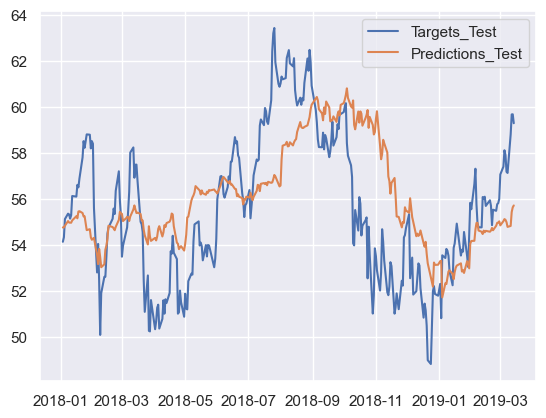

In [21]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

---

## Time to try our Random Feature model

#### Let's initialize our hyperparameters + latent parameters
These will be used in generating our (random) feature map

In [22]:
dim_data = X_train.shape[1] # <- Number of covariates

### Helper Functions

Well get our first "helper function".  These are intended to be used often (like lemata) to help with small individual tasks, which we frequently perform.  

#### Uniform Sampler 

In [23]:
def random_ball(num_points = dim_feature, dimension=dim_data, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

## Next let's write a little function to generate random features

Since we have set the correct default parameters for the theorem...let's just run it with an empty argument.

In [24]:
# Generate the random parameters determining our feature map
rand_weights = random_ball(radius=radius_weights)
rand_biases = random_ball(dimension = 1,radius=radius_bias)

**Note**: It's crucial to initialize the random matrix and random vectors externally to the random feature map.  Otherwise, everytime you run the code you'll be multiplying by a different matrix + adding a different vector.

*I.e.: You'll turn your features into pure noise :0*

In [25]:
def rand_feature_map(x_input):
    x_int = np.array(x_input).transpose()
    #Apply Random Weights
    x_int = rand_weights.dot(x_int).transpose()
    #Apply Random Bias
    x_int = x_int + rand_biases.transpose()
    #Apply ReLU activation function
    x_int = np.maximum(x_int,0)
    #Return Random Features
    return x_int

Next we apply our random feature map to each of our data points in X

This gives us our random features.

In [26]:
#Apply to each data
## first to the training dataset
X_Rand_Features_train = rand_feature_map(X_train)
X_Rand_Features_train = pd.DataFrame(X_Rand_Features_train)
## then to the testing dataset
X_Rand_Features_test = rand_feature_map(X_test)
X_Rand_Features_test = pd.DataFrame(X_Rand_Features_test)

# Vislualize things to make sure all is working
print('Train Shape')
print(X_Rand_Features_train.shape)
print(X_Rand_Features_train.head())
print('Test Shape')
print(X_Rand_Features_test.shape)
print('Test Features')
X_Rand_Features_test.head()

Train Shape
(453, 10000)
   0     1     2         3         4         5          6         7     \
0   0.0   0.0   0.0  0.550362  7.864804  0.951164  11.392673  1.824906   
1   0.0   0.0   0.0  0.550301  7.863255  0.950970  11.390841  1.824536   
2   0.0   0.0   0.0  0.551919  7.904565  0.956145  11.439685  1.834402   
3   0.0   0.0   0.0  0.555905  8.006293  0.968889  11.559964  1.858697   
4   0.0   0.0   0.0  0.554590  7.972728  0.964684  11.520279  1.850681   

       8     9     ...  9990      9991  9992  9993      9994      9995  9996  \
0  9.237244   0.0  ...   0.0  0.909576   0.0   0.0  5.635691  4.311732   0.0   
1  9.235714   0.0  ...   0.0  0.909532   0.0   0.0  5.634734  4.311024   0.0   
2  9.276504   0.0  ...   0.0  0.910714   0.0   0.0  5.660268  4.329898   0.0   
3  9.376948   0.0  ...   0.0  0.913624   0.0   0.0  5.723146  4.376373   0.0   
4  9.343807   0.0  ...   0.0  0.912664   0.0   0.0  5.702399  4.361039   0.0   

       9997       9998  9999  
0  1.252023  11.09

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.550362,7.864804,0.951164,11.392673,1.824906,9.237244,0.0,...,0.0,0.909576,0.0,0.0,5.635691,4.311732,0.0,1.252023,11.095635,0.0
1,0.0,0.0,0.0,0.550301,7.863255,0.950970,11.390841,1.824536,9.235714,0.0,...,0.0,0.909532,0.0,0.0,5.634734,4.311024,0.0,1.251783,11.093874,0.0
2,0.0,0.0,0.0,0.551919,7.904565,0.956145,11.439685,1.834402,9.276504,0.0,...,0.0,0.910714,0.0,0.0,5.660268,4.329898,0.0,1.258177,11.140835,0.0
3,0.0,0.0,0.0,0.555905,8.006293,0.968889,11.559964,1.858697,9.376948,0.0,...,0.0,0.913624,0.0,0.0,5.723146,4.376373,0.0,1.273923,11.256476,0.0
4,0.0,0.0,0.0,0.554590,7.972728,0.964684,11.520279,1.850681,9.343807,0.0,...,0.0,0.912664,0.0,0.0,5.702399,4.361039,0.0,1.268728,11.218321,0.0


We'll also include the original (untransformed features)

In [27]:
X_Rand_Features_train['Original_Features'] = np.array(X_train)
X_Rand_Features_test['Original_Features'] = np.array(X_test)

# Let's check all is working well
print(X_Rand_Features_train.head())
X_Rand_Features_test.head()

     0    1    2         3         4         5          6         7         8  \
0  0.0  0.0  0.0  0.550362  7.864804  0.951164  11.392673  1.824906  9.237244   
1  0.0  0.0  0.0  0.550301  7.863255  0.950970  11.390841  1.824536  9.235714   
2  0.0  0.0  0.0  0.551919  7.904565  0.956145  11.439685  1.834402  9.276504   
3  0.0  0.0  0.0  0.555905  8.006293  0.968889  11.559964  1.858697  9.376948   
4  0.0  0.0  0.0  0.554590  7.972728  0.964684  11.520279  1.850681  9.343807   

     9  ...      9991  9992  9993      9994      9995  9996      9997  \
0  0.0  ...  0.909576   0.0   0.0  5.635691  4.311732   0.0  1.252023   
1  0.0  ...  0.909532   0.0   0.0  5.634734  4.311024   0.0  1.251783   
2  0.0  ...  0.910714   0.0   0.0  5.660268  4.329898   0.0  1.258177   
3  0.0  ...  0.913624   0.0   0.0  5.723146  4.376373   0.0  1.273923   
4  0.0  ...  0.912664   0.0   0.0  5.702399  4.361039   0.0  1.268728   

        9998  9999  Original_Features  
0  11.095635   0.0          43.064

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Original_Features
0,0.0,0.0,0.0,0.550362,7.864804,0.951164,11.392673,1.824906,9.237244,0.0,...,0.909576,0.0,0.0,5.635691,4.311732,0.0,1.252023,11.095635,0.0,43.064999
1,0.0,0.0,0.0,0.550301,7.863255,0.950970,11.390841,1.824536,9.235714,0.0,...,0.909532,0.0,0.0,5.634734,4.311024,0.0,1.251783,11.093874,0.0,43.057499
2,0.0,0.0,0.0,0.551919,7.904565,0.956145,11.439685,1.834402,9.276504,0.0,...,0.910714,0.0,0.0,5.660268,4.329898,0.0,1.258177,11.140835,0.0,43.257500
3,0.0,0.0,0.0,0.555905,8.006293,0.968889,11.559964,1.858697,9.376948,0.0,...,0.913624,0.0,0.0,5.723146,4.376373,0.0,1.273923,11.256476,0.0,43.750000
4,0.0,0.0,0.0,0.554590,7.972728,0.964684,11.520279,1.850681,9.343807,0.0,...,0.912664,0.0,0.0,5.702399,4.361039,0.0,1.268728,11.218321,0.0,43.587502


As before...

#### Building and Training our Regression Model

In [28]:
model_linReg_randfeatures = LinearRegression()

First we train our model, with the "training" (a.k.a. in-sample) data.

In [29]:
model_linReg_randfeatures.fit(X_Rand_Features_train, Y_train)

LinearRegression()

It remains to train our random neural network (or random feature model)

In [30]:
# Instantiate Model
model_linReg_randfeatures = LinearRegression()
# Train Model
# fit model
model_linReg_randfeatures.fit(X_Rand_Features_train, Y_train)

LinearRegression()

Now we'll predict the test data given our input train data!

In [31]:
# Generate Prediction
Yhat_train_linReg_RF = model_linReg_randfeatures.predict(X_Rand_Features_train)
Yhat_train_linReg_RF = Yhat_train_linReg_RF.reshape([-1,])

We'll record our training performance while we're at it also.

In [32]:
Yhat_test_linReg_RF = model_linReg_randfeatures.predict(X_Rand_Features_test)
# Yhat_test_linReg = pd.DataFrame(Yhat_test_linReg)
Yhat_test_linReg_RF = Yhat_test_linReg_RF.reshape([-1,])

---

# Let's see how our new random feature model measures up

In [33]:
# Append Predictions to Dataframe
time_series_comparison['Predictions_Test_RF'] = Yhat_test_linReg_RF

# Check nothing went wrong (Safefy First!)
Yhat_test_linReg

array([54.74712787, 54.74409543, 54.8249643 , 55.02410328, 54.95839818,
       54.95637604, 54.95233174, 55.05240715, 55.23537204, 55.14439552,
       55.43855531, 55.45472785, 55.37386052, 55.2262747 , 55.23031745,
       54.94525655, 54.63087992, 54.67131359, 54.31246055, 54.21238514,
       54.2588837 , 54.29426432, 53.55836047, 53.15300732, 53.81410719,
       53.46131751, 53.0175513 , 53.14492028, 53.78176057, 53.94652923,
       54.25281881, 54.82092155, 54.76431226, 54.7056839 , 54.62683717,
       54.771389  , 55.07464613, 55.42541367, 55.36678378, 55.3394902 ,
       55.02410328, 55.14641767, 55.20808001, 55.19291623, 55.02713572,
       55.2202098 , 55.52750969, 55.70339938, 55.52649938, 55.37183837,
       55.3930655 , 55.32938256, 55.0544293 , 55.0483644 , 54.64705401,
       54.40242677, 54.00718127, 54.79868257, 54.35087207, 54.16285259,
       54.29426432, 54.18306942, 54.35592667, 54.68142278, 54.80171502,
       54.35491636, 54.52372932, 54.84720328, 54.7653241 , 54.93

## Let's Visualize How we did with our random Features!

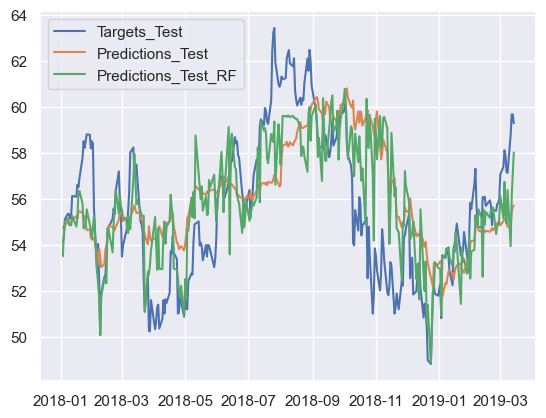

In [34]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()

# Plot!
plt.plot(time_series_comparison)

# Now we'll need a legend also
plt.legend(time_series_comparison.columns);

To get a better look, let's plot the time-series of squared prediction errors!

In [35]:
# Get timeseries of Squred prediction errors, for vanilla regression model!
SSE_LinReg = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test'])**2

# Get timeseries of Squred prediction errors, for random feature model!
SSE_LinReg_RF = np.abs(time_series_comparison['Targets_Test'] - time_series_comparison['Predictions_Test_RF'])**2

We'll make a pandas dataframe!

In [36]:
# Append Predictions to Dataframe
time_series_comparison_errors = pd.DataFrame({'Lin. Reg.':SSE_LinReg,'Lin. Reg. + RF':SSE_LinReg_RF})

# Check nothing went wrong (Safefy First!)
time_series_comparison_errors.head()

,Lin. Reg.,Lin. Reg. + RF
Date,,
2018-01-03,0.388288,0.394497
2018-01-04,0.179857,0.063024
2018-01-05,0.082103,0.010499
2018-01-08,0.104262,0.039597
2018-01-09,0.125742,0.208219


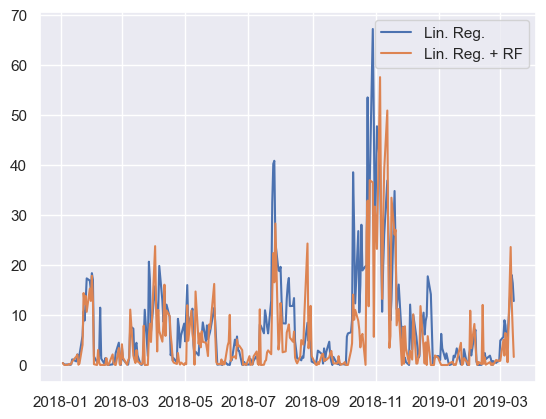

In [37]:
# Activate Seaborn (<- this makes plots pretty :3)
sns.set()

# Plot!
plt.plot(time_series_comparison_errors)

# Now we'll need a legend also
plt.legend(time_series_comparison_errors.columns);

Let's look at some statistics to see when and if we ever do better with the random feature?

Typically, is:

time_series_comparison_errors['Lin. Reg.'] > time_series_comparison_errors['Lin. Reg. + RF']?

I.e. is this quantity positive?

In [38]:
print('Average gain by random features') 
np.mean(time_series_comparison_errors['Lin. Reg.']-time_series_comparison_errors['Lin. Reg. + RF'])

Average gain by random features


2.151253079231709

What about the variance in the two model's errors?

In [39]:
print('Variance')
np.var(time_series_comparison_errors['Lin. Reg.']-time_series_comparison_errors['Lin. Reg. + RF'])

Variance


44.43945758761643

How often are the random features paying off?

In [40]:
print('Linear Regression has a larger error')
print(np.mean(time_series_comparison_errors['Lin. Reg.']>time_series_comparison_errors['Lin. Reg. + RF']))
print('percent of the time!')

Linear Regression has a larger error
0.6266666666666667
percent of the time!


---

# What conclusion do you draw?